# Scoring Model for Bank Churn Prediction ⚖📜

Given the credit risk inspired theme for the first Kaggle 2024 playground competion, I thought I would take a break from the decision tree based techniques, the emsemble models, and go back to the basics: a **scorecard**!

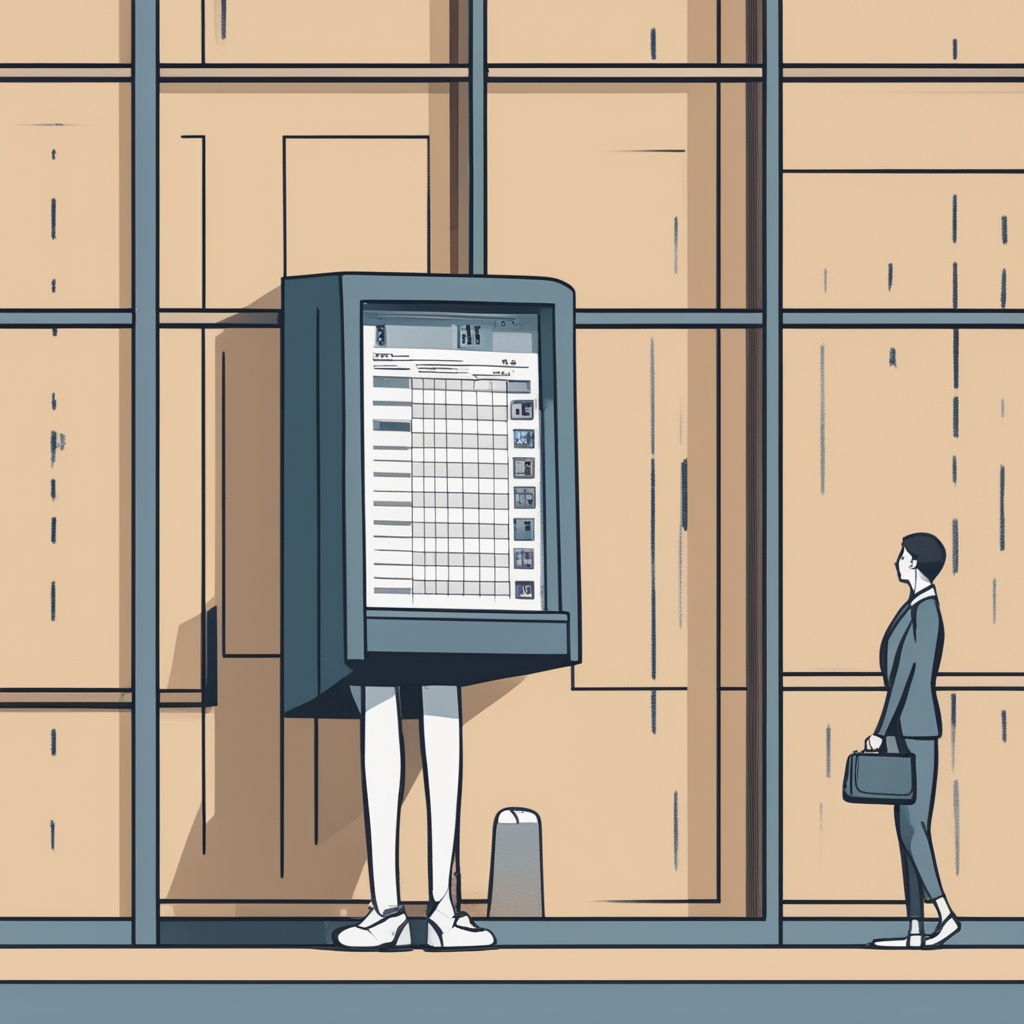

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.table import Table
import seaborn as sns
import math
import xgboost as xgb
import shap
import optuna
from collections import OrderedDict
from optuna import Trial
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from scipy.stats import linregress

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv
/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv


In [2]:
!git clone https://github.com/VassMorozov/Weights-of-Evidence

Cloning into 'Weights-of-Evidence'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 31 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), 11.12 KiB | 271.00 KiB/s, done.


In [3]:
import sys
sys.path.append('Weights-of-Evidence')

In [4]:
from woe import WeightsOfEvidence

In [5]:
train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')

# Bring in additional data
df = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')

An exploratory data analysis was completed as part of a previous notebook. Here I will focus on the development of an interpretable scoring model and showcase some analyses associated with presenting and validating this.

<div class="alert alert-block alert-info"> ⚠ A word of warning, this notebook contains a bit of maths. It is not essential to read but hopefully helpful for those that are not familiar with how a logistic regression output is converted to a score. </div>

# 1. Read in Data

In [6]:
train.drop(columns=['id', 'Surname', 'CustomerId'], inplace=True)
test.drop(columns=['id', 'Surname', 'CustomerId'], inplace=True)
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [7]:
# Some missings present in the non-competition dataset are dropped here
df.dropna(inplace=True)

In [8]:
# Append all training data
train = pd.concat([train, df])

In [9]:
# Define numeric and categorical column sets for dummy creation and Weights of evidence allocation
numeric_columns = train.select_dtypes(include='number').columns.tolist()
categorical_columns = train.select_dtypes(include='object').columns.tolist()
numeric_columns.remove('Exited')

# The EDA notebook showed that certain numeric variables were discrete and could be treated as categorical.
categorical_columns.extend(['HasCrCard', 'IsActiveMember', 'NumOfProducts'])
numeric_columns.remove('HasCrCard')
numeric_columns.remove('IsActiveMember')
numeric_columns.remove('NumOfProducts')

In [10]:
# Create dummies of categorical variables
train = pd.get_dummies(train, columns=categorical_columns, drop_first=True, dtype=int)
test = pd.get_dummies(test, columns=categorical_columns, drop_first=True, dtype=int)

# 2. Applying Weights of Evidence Transformation

For this logistic regression model, we will transform continuous variables into their weights of evidence form. This is done instead of any feature scaling. It is applied to grouped or coarse variables using the following formula:

$\text{WoE} = \ln\left(\frac{\text{Distribution of Bad in the Group}}{\text{Distribution of Good in the Group}}\right)$

Given we have continuous variables such as age,we will need to do some grouping. I have written a class to do this and imported it from my Github repo to avoid a mass of code in this notebook. My grouping mechanism will be using decision trees to produce optimal splits for each continuous feature. I could use a similar approach but using decision trees ensures optimal purity in each group. The quality of the groups can be assessed later when we look at some plots.

In [11]:
X_y_train, X_y_test = train_test_split(train, stratify=train['Exited'], test_size=0.15, 
                                                    random_state=4131)

In [12]:
# We will want WoE transformation for all test data so append together for now, labelling each to remember which is which
X_y_test['Test'] = 0
test['Test'] = 1

all_test_data = pd.concat([X_y_test, test])

In [13]:
woe = WeightsOfEvidence(X_y_train, numeric_columns, 'Exited', 
                        grouping_method='decision_tree', depth = 4, min_samples=100,
                       random_state=42, add_data=all_test_data)

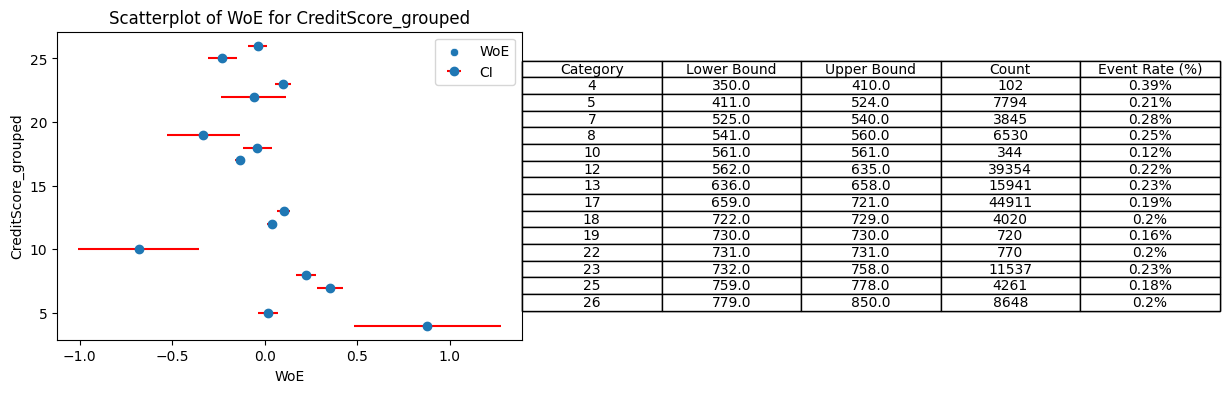

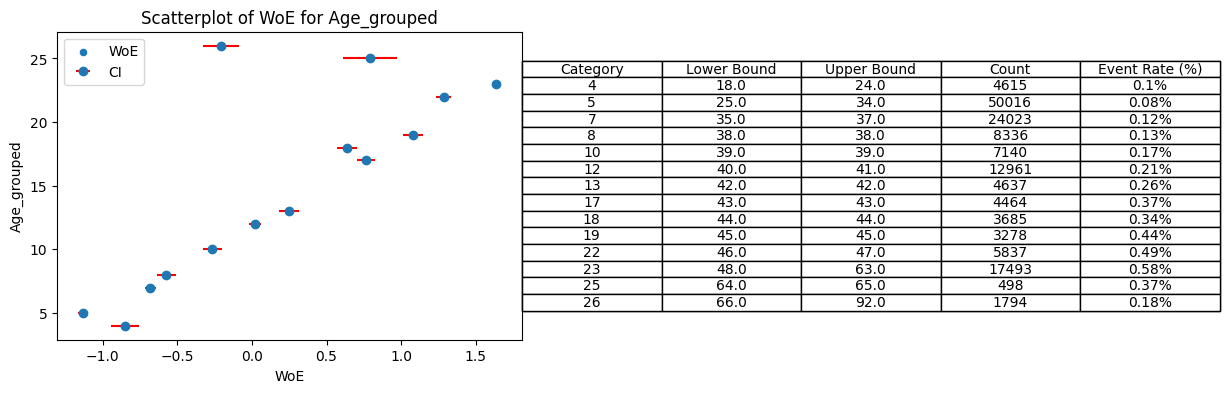

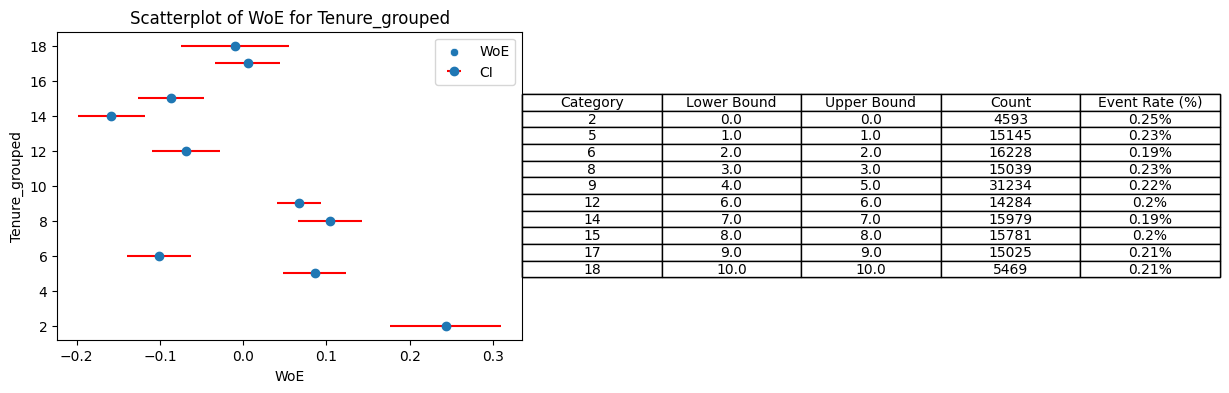

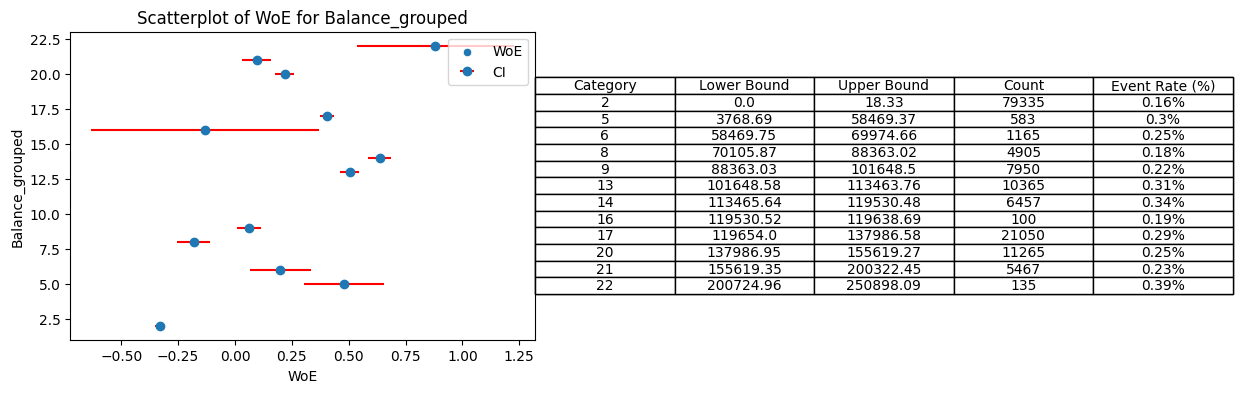

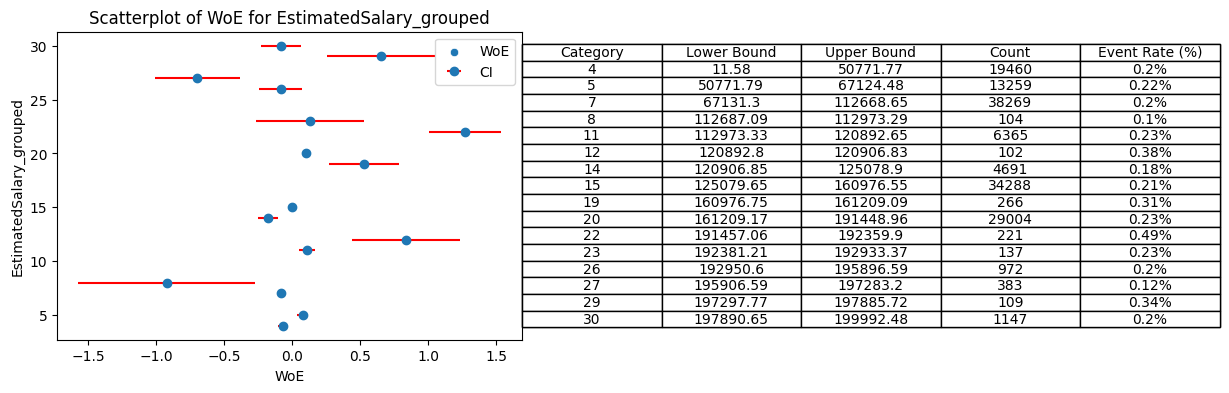

In [14]:
woe.plot_woe()

**OK**, so some of the grouping does not appear to be great. In most interpretable scoring models what we want is nice monotonic groups where the event rate is going in one direction, but here it is a bit all over the place.

Lets have a look at some of the graphs. Each graph has the groups weight of evidence as well as a 95% confidence interval around it. Wide confidence intervals implies a low total, exit or non-exit volume leading to uncertainty in the weights of evidence allocation. When building these sorts of models normally, you would consider grouping variables with overlapping weights of evidence as these will have similar exit patterns. 

For example, consider the EstimatedSalary feature. The event rate column does not show any sign of monotonicity and the majority of the groups have an exit rate around 0.2% (group 4, 5, 7 ect.). This probably means it is not a great feature in this form. As well as this, we can't really make a qualitiative argument here supporting the features pattern: customers with lower salaries (less than 50,771.77) seem to behave almost the same as those with higher salaries (greater than 199,992.48).

On the other, consider the Age characteristic. The event rate goes in a neat monotonic trend, with the likelihood of leaving the bank increasing with age. The confidence intervals are narrow and the groups are nicely spread so we could probably even squeeze some more power out of this feature by applying further splitting. We can even tell a qualitative story here: someone older is more likely to leave the bank as they are financially savvy and know how to shop around better than someone younger. I am making this up but its a plausible story?

An iterative process could start here to improve the feature grouping and recalculate but given I am just using this as an illustrative exercise, I will move on.

In [15]:
# Now need to assign the WoE back to our data
woe_cols = [col for col in woe.df.columns if '_woe' in col]
grouped_cols = [col for col in woe.df.columns if '_grouped' in col]

X_y_test = pd.concat([X_y_test, woe.add_data.loc[woe.add_data['Test']==0, woe_cols]], axis=1)
test = pd.concat([test, woe.add_data.loc[woe.add_data['Test']==1, woe_cols]], axis=1)

***

# 3. Fitting a Logistic Regression Model
There are not many hyperparameters to a logistic regression, but we will explore different regularization types as well as penalty values. To do this, we will use the Optuna framework.

In [16]:
# Drop the original columns as want the WoE transformed ones for the scorecard
X_y_train.drop(columns=numeric_columns, inplace=True)
X_y_train.drop(columns=grouped_cols, inplace=True)
X_y_test.drop(columns=numeric_columns, inplace=True)
X_y_test.drop(columns=['Test'], inplace=True)
test.drop(columns=numeric_columns, inplace=True)
test.drop(columns=['Test'], inplace=True)

In [17]:
def logistic_study(trial):
    
    # Define training and test X and y
    X_train = X_y_train.loc[:, [col for col in X_y_train.columns if col != 'Exited']]
    X_test = X_y_test.loc[:, [col for col in X_y_test.columns if col != 'Exited']]
    y_train = X_y_train.loc[:, 'Exited']
    y_test = X_y_test.loc[:, 'Exited']
    
    # Define hyperparameters to be optimized
    C = trial.suggest_loguniform('C', 1e-5, 1e5)
    penalty = trial.suggest_categorical('penalty', [None, 'l2'])

    # Create a logistic regression model with the suggested hyperparameters
    model = LogisticRegression(C=C, penalty=penalty, solver='newton-cholesky')

    # Train the model on the training data
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1
        
    return roc_auc_score(y_test, y_pred_proba)

# Create an Optuna study and optimize the logistic regression model
study = optuna.create_study(direction='maximize')
study.optimize(logistic_study, n_trials=20, show_progress_bar=True)

[I 2024-01-22 20:52:52,799] A new study created in memory with name: no-name-c539f557-a4f1-481a-8b6b-98bb4721c664


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-01-22 20:52:53,173] Trial 0 finished with value: 0.8752507189750683 and parameters: {'C': 0.00013082143015729307, 'penalty': None}. Best is trial 0 with value: 0.8752507189750683.
[I 2024-01-22 20:52:53,516] Trial 1 finished with value: 0.8752489335995686 and parameters: {'C': 3.6200664201192625, 'penalty': 'l2'}. Best is trial 0 with value: 0.8752507189750683.
[I 2024-01-22 20:52:53,845] Trial 2 finished with value: 0.8752470437142833 and parameters: {'C': 1.4154751957818286, 'penalty': 'l2'}. Best is trial 0 with value: 0.8752507189750683.
[I 2024-01-22 20:52:54,187] Trial 3 finished with value: 0.8752507189750683 and parameters: {'C': 3.1862461916523244, 'penalty': None}. Best is trial 0 with value: 0.8752507189750683.
[I 2024-01-22 20:52:54,533] Trial 4 finished with value: 0.8752507189750683 and parameters: {'C': 5191.71530883654, 'penalty': None}. Best is trial 0 with value: 0.8752507189750683.
[I 2024-01-22 20:52:54,872] Trial 5 finished with value: 0.8752507102659197 an

Not entirely surprising that the best performance does not include regularization and that hyperparameter tuning does not make much difference to this type of model but anyway...

In [18]:
# Take the best model (although as can be seen, very little difference was made!)
logistic_model = LogisticRegression(**study.best_params,random_state=42)
logistic_model.fit(X_y_train.loc[:, [col for col in X_y_train.columns if col != 'Exited']], X_y_train.loc[:, 'Exited'])

LogisticRegression(C=0.00013082143015729307, penalty=None, random_state=42)

In [19]:
y_pred_proba = logistic_model.predict_proba(X_y_test.loc[:, [col for col in X_y_test.columns if col != 'Exited']])[:, 1]

# Evaluate the model performance using area under the curve
score = roc_auc_score(X_y_test.loc[:, 'Exited'], y_pred_proba)
print("AUC on test set:", score)

AUC on test set: 0.8752503880274147


**Wow!** A decent score for an old fashioned Logistic Regression!

***

For us data scientists, this could be an easy enough place to stop. When talking about someone leaving a bank we know the probability they will leave and we know we have a good idea of the accuracy of this probability from everything we have done before.

**But regular people rarely care about probabilities...**

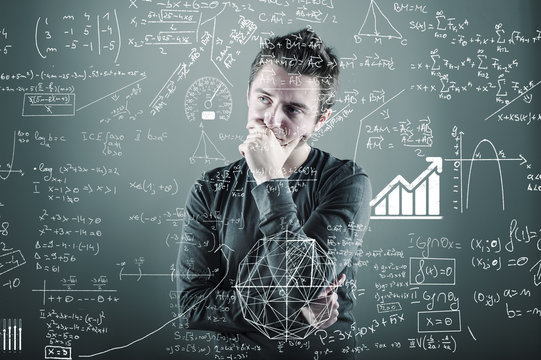

How do we make this probability more interpretable? For this we can use a scorecard! 

Unfortunately for any regular people reading, it gets harder before it gets easier with a little help from our old friend **maths**...

# 4. Introducing the Scorecard

To convert the logistic regression output to a score, the probability must be calibrated. We can do this using the following formula:

$\text{Score} = \ln\left(\frac{1- P(Y=1)}{P(Y=1)}\right)*\frac{\text{PDO}}{\ln2} + \text{1:1 Odds}$ 

Where:
- $\ln\left(\frac{1- P(Y=1)}{P(Y=1)}\right)$ is the log odds,
- $P(Y=1)$ is the output of the logistic regression after applying the logistic function in the following way
$P(Y=1) = \frac{1}{1+\exp{\beta_0 + \sum_{i=1}^{n} \beta_i X_i}}$
- $\text{PDO}$ represents the points to double the odds,
- $\ln2$ is a constant used because we are doubling the odds.

For credit scoring models, a typical calibration is **500** for 1:1 odds and **20** points to double the odds so we will use this.

In [20]:
pdo = 20
one_to_one = 500

In [21]:
# Get probability from model
X_y_train['pExit'] = logistic_model.predict_proba(X_y_train.loc[:, [col for col in X_y_train.columns if col != 'Exited']])[:, 1]
X_y_test['pExit'] = logistic_model.predict_proba(X_y_test.loc[:, [col for col in X_y_test.columns if col != 'Exited']])[:, 1]

# Calibrate score based on our pdo and 1:1 odds
X_y_train['Score'] = np.log((1-X_y_train['pExit']) / X_y_train['pExit']) * (pdo/np.log(2)) + one_to_one
X_y_test['Score'] = np.log((1-X_y_test['pExit']) / X_y_test['pExit']) * (pdo/np.log(2)) + one_to_one

Text(0.5, 1.0, 'Test')

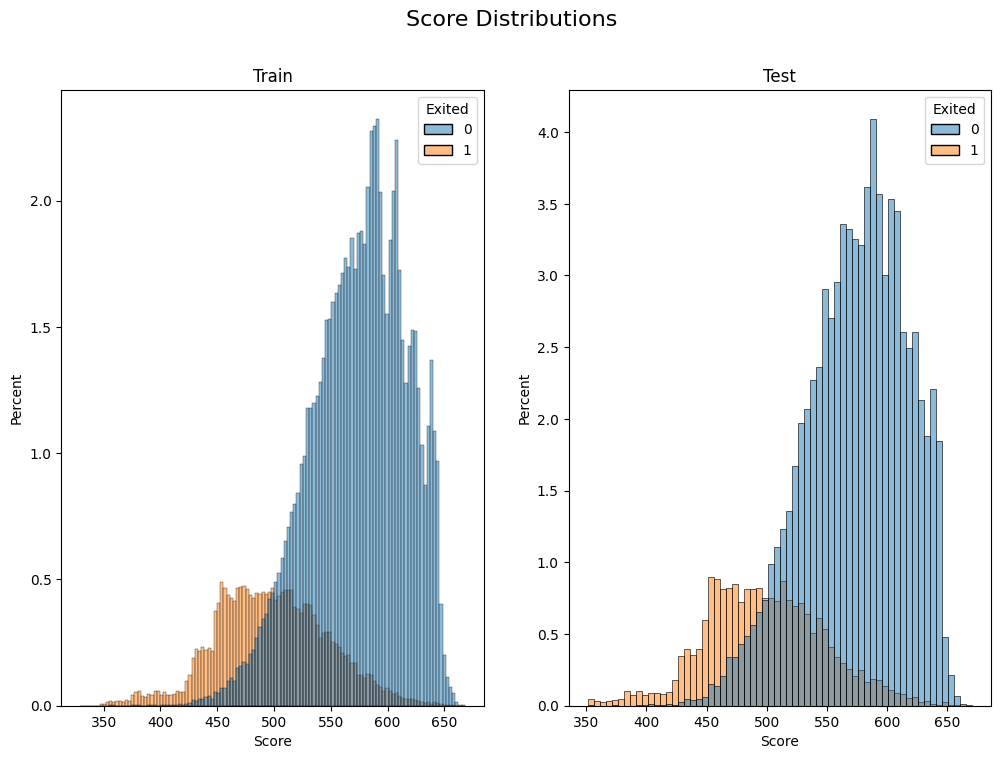

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(12,8))

# Plot distribution of score
fig.suptitle('Score Distributions', fontsize=16)
sns.histplot(data=X_y_train, x='Score', stat='percent', hue='Exited', ax=ax[0])
sns.histplot(data=X_y_test, x='Score', stat='percent', hue='Exited', ax=ax[1])
ax[0].set_title('Train')
ax[1].set_title('Test')

A good validation to show our score is working properly is noting that those that exited (```Exited==1```) are scoring lower in our model. I have set the score to work this way however it can easily be flipped by changing the formulation of the odds to:

$\large \frac{P(Y=1)}{1-P(Y=1)}$

**Great!** That was easy, but what is my score made of? What makes me get a score of 450 versus 600?

To understand this, we need to consider each features contribution to the score. With some more maths, we can figure this out!

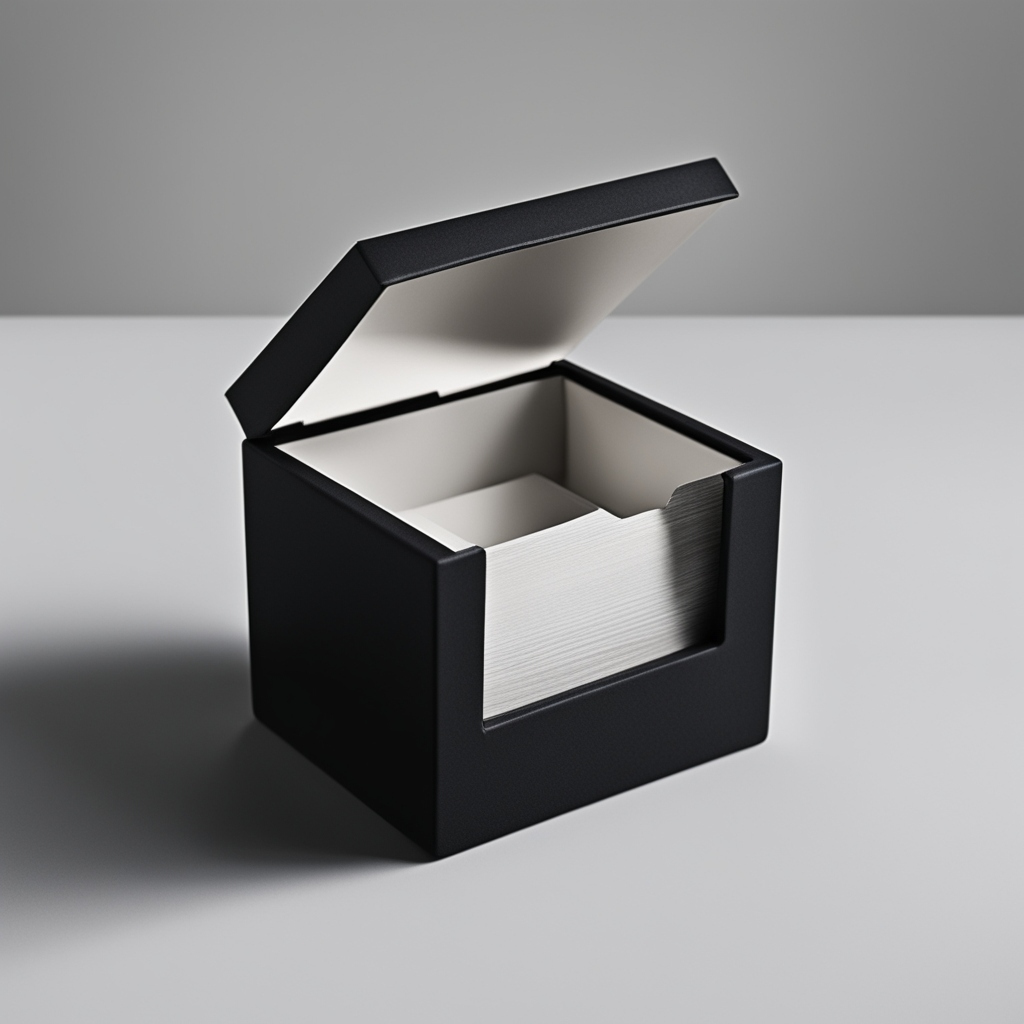

For a logistic regression, the log odds can be expressed as follows:

$\large \ln\left(\frac{1- P(Y=1)}{P(Y=1)}\right) = \beta_0 + \sum_{i=1}^{n} \beta_i X_i$

where:
- $ \beta_0 $ is the intercept of the model,
- $ \beta_i, $ is the coefficient for the feature $X_i$
- $ n $ is the number of features

This is the basic property of the logistic regression as generalised linear model, where the odds follow an exponential distribution.

We have calibrated this output to create a score. Rearranging the previously provided $\text{Score}$, the following expression can be derived:

$\text{Score} = \underbrace{\frac{\text{PDO}}{\ln2}*\sum_{i=1}^{n} \beta_i X_i}_\text{Feature Contribution} + \overbrace{(\frac{\text{PDO}*\beta_0}{\ln2} +\text{1:1 Odds})}^\text{Constant}$

So for any feature $X_i$, the marginal contribution to $\text{Score}$ is:

$ Contribution_i = \frac{\beta_i * X_i * \text{PDO}}{\ln2} $

For cleanliness, we can also redistribute the constant across each feature to make the score a function of only the features. This way, the $Contribution_i$ becomes:

$ Contribution_i = \frac{\beta_i * X_i * \text{PDO}}{\ln2} + \frac{(\frac{\text{PDO}*\beta_0}{\ln2} +\text{1:1 Odds})}{n}$

In [23]:
# Using equations above we can convert each feature to its marginal contribution
_const = (one_to_one + (-logistic_model.intercept_ * (20 / np.log(2)))) / len(logistic_model.coef_[0]) 

count = 0
for coef in logistic_model.coef_[0]:

    feature = logistic_model.feature_names_in_[count]
    
    # Rounding may mean that the sum is not perfect but it will be close enough
    X_y_train[f'{feature}_score'] = round(((-coef * X_y_train[feature]) * (20 / np.log(2))) + _const, 1)
    X_y_test[f'{feature}_score'] = round(((-coef * X_y_test[feature]) * (20 / np.log(2))) + _const, 1)
    
    count += 1

In [24]:
X_y_train['Sum of Contributions'] = X_y_train.loc[:, [f'{feature}_score' for feature in logistic_model.feature_names_in_]].sum(axis=1)
X_y_train.loc[:, ['Score', 'Sum of Contributions']]
# Although rounding may lose some of the model performance, it is a necessary step for interpretability purposes - particularly in credit risk!

,Score,Sum of Contributions
91717,589.389623,589.6
99347,561.087611,561.2
10702,564.503281,564.6
1443,600.987342,601.0
159878,463.679042,463.8
...,...,...
61879,521.168201,521.3
36981,466.348792,466.4
68171,579.310176,579.4
102917,638.213404,638.4


In [25]:
# Dropping this now as was only included for a demonstration
X_y_train.drop(columns=['Sum of Contributions'], inplace=True)

In [26]:
# Utility function for renaming the variables
def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

od = OrderedDict([("_woe", ""), ("_score", "")])

# Lets visualise these marginal contributions and get a feel for the distributions
def plot_categorical_table(data, categorical_columns, target_column):

    fig, axes = plt.subplots(len(categorical_columns), 1, figsize=(10, 6 * len(categorical_columns)))

    for i, column in enumerate(categorical_columns):
        # Group by the categorical column and calculate counts
        grouped_data = data.groupby(column)[target_column].agg(['count', 'sum'])

        # Calculate event rate and percentage of total population
        # Calculate event rate and percentage of total population
        grouped_data['Event Rate'] = (grouped_data['sum'] / grouped_data['count']).map('{:.2%}'.format)
        grouped_data['Percentage of Total Population'] = (grouped_data['count'] / grouped_data['count'].sum()).map('{:.2%}'.format)
        
        # Rename the columns for clarity
        grouped_data = grouped_data.rename(columns={'count': 'Total Count', 'sum': 'Event Count'})

        # Reset the index to make the grouped column a regular column
        grouped_data = grouped_data.reset_index()
        
        # Rename this column to be original feature name
        grouped_data.rename(columns={column:replace_all(column, od)}, inplace=True)

        # Display the table in a subplot
        ax = axes[i] if len(categorical_columns) > 1 else axes
        ax.axis('off')
        _table = ax.table(cellText=grouped_data.values,
                 colLabels=grouped_data.columns,
                 cellLoc='center',
                 colWidths=[0.3, 0.3, 0.3, 0.3, 0.3],
                 loc='center')
        _table.scale(1, 1.5)
        _table.set_fontsize(14)
        
        ax.set_title(f'Table for {replace_all(column, od)}')

    plt.show()



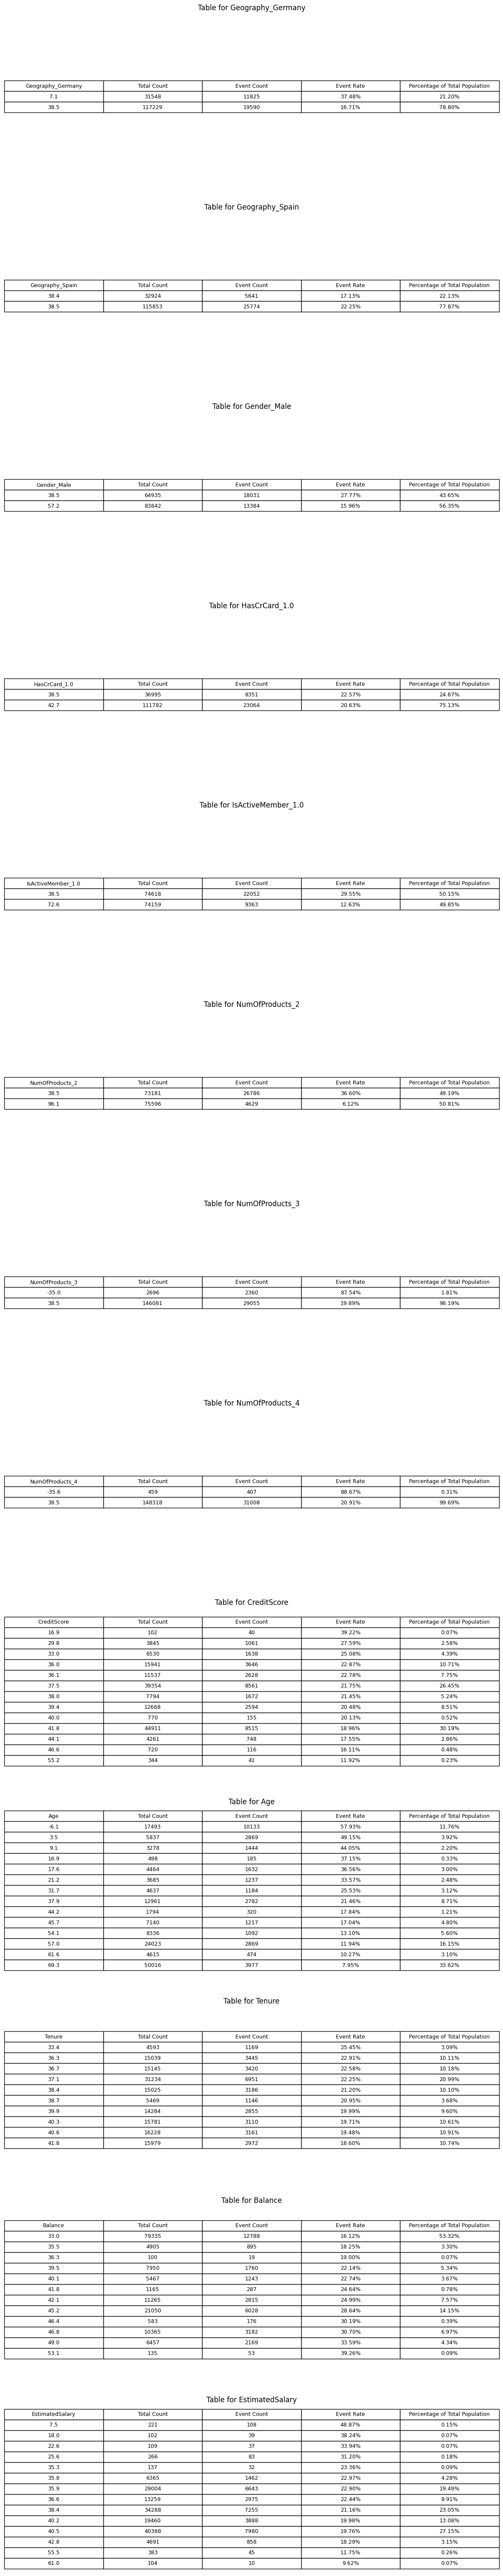

In [27]:
# Show the distribution of the scorecard in summary tables for each characteristic
partials = [f'{feat}_score' for feat in logistic_model.feature_names_in_]
plot_categorical_table(X_y_train, partials, 'Exited')

And there you have it, we can explain where our scoring population is sitting across each feature. We can explain the rank of each characteristic, for example, the older you are the more likely you are to leave the bank! If someone questions a score, I can tell them based on an age, salary and a number of other features exactly why they are more or less likely to leave the bank and whether these people should have some additional promotion applied to try and keep them!

# 5. Validation: Score versus odds analysis
A good piece of validation is looking at how model is performing across the score range and whether there is any over or under estimation being displayed when comparing actual versus expected odds.

We do this by banding our scores and looking at the actual and expected odds. Given a logistic regression is a generalised linear model, we can fit an exponential curve (which becomes a line in logarithmic scale) to our actual and expected odds to assess the fit of our individual score bands. Our actual odds involve looking at the observed exit rate for each score band. For the expected odds, we convert our score back to its probability and calculating the odds from this based on our provided calibration. 

Remember that:

$\text{Score} = \ln\left(\frac{1- P(Y=1)}{P(Y=1)}\right)*\frac{\text{PDO}}{\ln2} + \text{1:1 Odds}$ 

Rearranging we get:

$\frac{(\text{Score} - \text{1:1 Odds})*\ln2}{\text{PDO}}= \ln\left(\frac{1- P(Y=1)}{P(Y=1)}\right) $ 

Taking the exponent on both sides you get:

$\exp{\frac{(\text{Score} - \text{1:1 Odds})*\ln2}{\text{PDO}}} = \frac{1- P(Y=1)}{P(Y=1)}$

This gives us the odds, but we want to plot it in a linear scale so we rearrange to get the probability as:



I touched upon the formulation of $P(Y=1)$ earlier but said I would come back to it and here we are! The probability of exiting in a logistic regression involves applying a logistic function in the following way:

$P(Y=1) = \frac{1}{1+\exp{\frac{(\text{Score} - \text{1:1 Odds})*\ln2}{\text{PDO}}}}$

From this, we can then calculate the expected odds to show how our actual fit compares to the expected given our specified calibration!

In [28]:
def plot_score_vs_odds(data_list, score_column, target_column, titles=None):
    
    num_subplots = len(data_list)
    
    # Create subplots based on the number of DataFrames in the list
    fig, axes = plt.subplots(nrows=num_subplots, ncols=1, figsize=(12, 8))

    for i, data in enumerate(data_list):

        # Create score bands of 10
        data['Score Band'] = pd.cut(data[score_column], bins=range(0, int(data[score_column].max()) + 11, 10))

        # Calculate the odds within each score band
        grouped_data = data.groupby('Score Band')[[score_column, target_column]].mean()
        grouped_data['Odds'] = (1 - grouped_data[target_column]) / grouped_data[target_column]

        # Where there are 0 observed exits, replace with nan to drop
        grouped_data['Odds'] = grouped_data['Odds'].replace([np.inf, -np.inf], np.nan).dropna()
        grouped_data.dropna(inplace=True)
        
        # Get expected line for plotting too
        exponent = (grouped_data[score_column] - one_to_one) * (np.log(2) / pdo) 
        e_prob = (1 / (1 + np.exp(-exponent)))
        grouped_data['Expected Exited'] = 1 - e_prob
        grouped_data['Expected Odds'] = e_prob / (1-e_prob)
        
        # Need to get line of best fit which is in log scale
        p = np.polyfit(np.log(grouped_data[score_column].loc[(grouped_data['Odds']!=0)]), np.log(grouped_data['Odds'].loc[(grouped_data['Odds']!=0)]), 1)
        grouped_data['Fitted'] = np.exp(np.polyval(p, np.log(grouped_data[score_column])))

        # Parameters for Expected line
        p = np.polyfit(np.log(grouped_data[score_column]), np.log(grouped_data['Expected Odds']), 1)
        grouped_data['Expected'] = np.exp(np.polyval(p, np.log(grouped_data[score_column])))

        # Plot the score versus odds graph for each score band using Seaborn
        act = sns.scatterplot(x=grouped_data[score_column], y=grouped_data['Odds'], s=50, color='blue', ax=axes[i], label='Actual')
        exp = sns.lineplot(x=grouped_data[score_column], y=grouped_data['Expected'], color='green',linestyle="dashed", ax=axes[i], label='Expected')
        fit = sns.lineplot(x=grouped_data[score_column], y=grouped_data['Fitted'], color='red', ax=axes[i], label='Fitted')

        axes[i].legend(loc=0)
        axes[i].set_yscale('log')
        axes[i].set_xlabel('Score')
        axes[i].set_ylabel('Odds')
        axes[i].set_title(f'Score versus Odds Graph - {titles[i]}')
        plt.tight_layout()

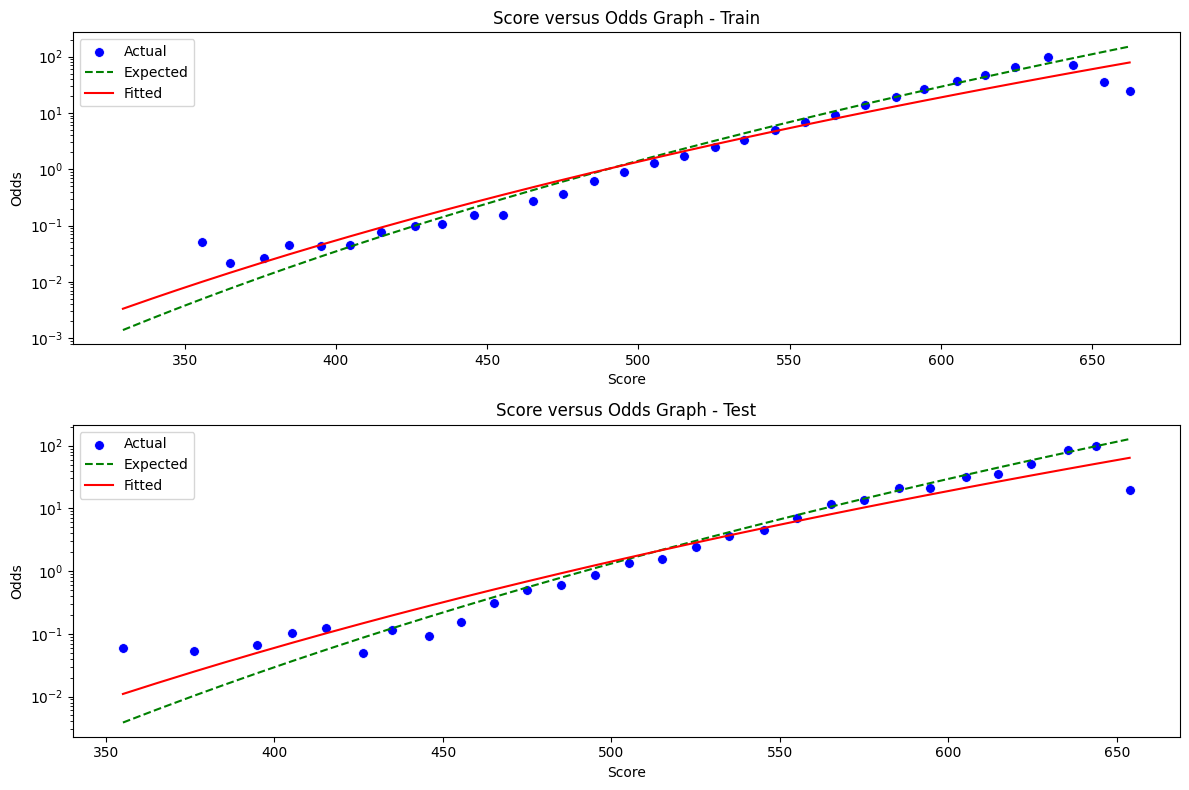

In [29]:
plot_score_vs_odds([X_y_train, X_y_test], 'Score', 'Exited', titles=['Train', 'Test'])

There is a similar theme on both the training and test samples. We are overestimating the  the chance of someone exiting the bank at the lower scoring end (between 350 and ~420 points) with slight underestimation at the higher scoring end (greater than 550 points).There is less volume at both the tails which explains the slightly curved odds (0 non-exits at 350 points 1 exit at 660-670).